In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#Function to visualize a pair of sequence logos
def visualize_input_gradient_pair(att_grad_wt, att_grad_mut, plot_start=0, plot_end=100, save_figs=False, fig_name='') :

    scores_wt = att_grad_wt[plot_start:plot_end, :]
    scores_mut = att_grad_mut[plot_start:plot_end, :]

    y_min = min(np.min(scores_wt), np.min(scores_mut))
    y_max = max(np.max(scores_wt), np.max(scores_mut))

    y_max_abs = max(np.abs(y_min), np.abs(y_max))

    y_min = y_min - 0.05 * y_max_abs
    y_max = y_max + 0.05 * y_max_abs

    if np.sum(scores_mut) != 0. :
        print("--- WT ---")
    
    plot_seq_scores(
        scores_wt, y_min=y_min, y_max=y_max,
        figsize=(8, 1),
        plot_y_ticks=False,
        save_figs=save_figs,
        fig_name=fig_name + '_wt',
    )

    if np.sum(scores_mut) != 0. :
    
        print("--- Mut ---")
        plot_seq_scores(
            scores_mut, y_min=y_min, y_max=y_max,
            figsize=(8, 1),
            plot_y_ticks=False,
            save_figs=save_figs,
            fig_name=fig_name + '_mut',
        )


In [2]:
#Load scores

score_file = h5py.File('../../../borzoi/examples/saved_models/gtex_CD99/scores_f3c0.h5', 'r')

scores = score_file['grads'][()][:, :, :, 0]
seqs = score_file['seqs'][()][:]
genes = score_file['gene'][()][:]
genes = np.array([genes[j].decode() for j in range(genes.shape[0])])
strands = score_file['strand'][()][:]
strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

#Input-gate the scores
scores = scores * seqs

print("scores.shape = " + str(scores.shape))


scores.shape = (1, 524288, 4)


-- 0 (+) --
 - gene_id = 'ENSG00000002586.20


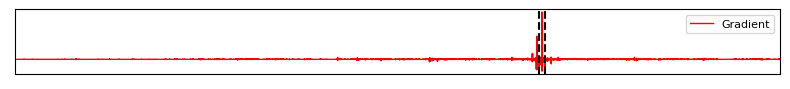

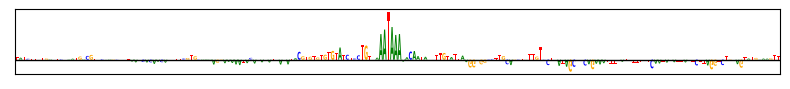

In [5]:
#Visualize polya-centric gradient for gene(s)

#Find position of max saliency
max_poses = np.argmax(np.sum(scores, axis=-1), axis=-1)

#Loop over genes
for example_ix in range(scores.shape[0]) :
    
    #Get max pos
    max_pos = max_poses[example_ix]
    
    #Only visualize genes that are not extremely long
    if max_pos >= 150000 and max_pos < seqs.shape[1] - 150000 :
        
        print("-- " + str(example_ix) + " (" + str(strands[example_ix]) + ") --")
        print(" - gene_id = '" + str(genes[example_ix]))

        #Plot scores
        f = plt.figure(figsize=(8, 1))

        #Annotate 4kb window
        plot_start = max_pos - 2000
        plot_end = max_pos + 6 + 2000

        l1 = plt.plot(np.arange(seqs.shape[1]), np.sum(scores[example_ix, ...], axis=-1), linewidth=1, linestyle='-', color='red', label='Gradient')

        plt.axvline(x=plot_start, color='black', linestyle='--')
        plt.axvline(x=plot_end, color='black', linestyle='--')

        plt.xlim(0, seqs.shape[1])
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])

        plt.tight_layout()

        plt.show()
        
        #Visualize contribution scores
        plot_start = max_pos - 100
        plot_end = max_pos + 6 + 100
        
        #Rev-comp scores if gene is on minus strand
        if strands[example_ix] == '-' :
            plot_end = seqs.shape[1] - (max_pos - 100)
            plot_start = seqs.shape[1] - (max_pos + 6 + 100)
        
        #Plot sequence logo
        visualize_input_gradient_pair(
            scores[example_ix, :, :] if strands[example_ix] == '+' else scores[example_ix, ::-1, ::-1],
            np.zeros(scores[example_ix, ...].shape),
            plot_start=plot_start,
            plot_end=plot_end,
            save_figs=False,
        )
